# **Challenge 2 - K Nearest Neighbors**
* Sahil Gill, Luke Ingram
* MATH 318 - Winter 2023      

In [31]:

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
from tqdm import tqdm 
import numpy as np 
import pandas as pd
import cv2
import glob
import os


## **Section 1 - Loading the Data**

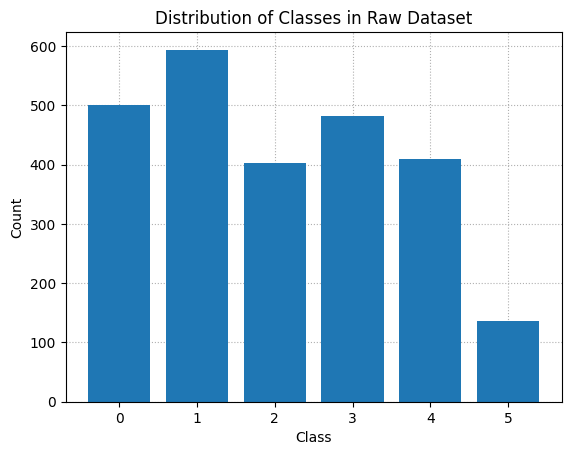

In [32]:
TARGET_NAMES =["Glass","Paper","Cardboard","Plastic","Metal","Trash"]

dirName = "../src/data/archive/zero-indexed-files.txt"
imgPath = "../src/data/archive/Garbage_classification/load/"

df = pd.read_csv(dirName,sep=' ')
df['image'] = imgPath + df['image'].astype(str)
df['image'] = df['image'].apply(lambda x: cv2.imread(x))

plt.clf()
plt.rc('axes', axisbelow=True)
plt.grid(linestyle='dotted')
temp = plt.bar(list(range(6)),
                np.unique(df['class'],return_counts=True)[1])
_ = plt.title("Distribution of Classes in Raw Dataset")
_ = plt.xlabel("Class")
_ = plt.ylabel("Count")

plt.show()

In our dataset the class labels are assigned as follows:

1. Glass

2. Paper

3. Cardboard

4. Plastic

5. Metal

6. Trash

Above, we've prepared a dataframe containing filepaths and their respective classes. Now we need to extract our design matrix.

Previously, we introduced SIFT, an algorithm for keypoint and image descriptor generation. The algorithm outputs a keypoint object, a datatype that efficiently encodes both the keypoints and image descriptors for each image. However, if we use KNN, we must transform our data into a discrete set of features whose entries can be evaluated with a distance metric.

## **Section 2 - Data Quantization**
The process of generating said feature space involves three steps.

1. **Extracting Keypoints & Descriptors**

2. **Clustering** (Feature Reduction)

3. **Normalization & Discretization**

**Section 2.1 - Keypoints and Descriptors**

Given the definitions of Keypoints and Descriptors in the previous challenge, let's consider the code needed to compute these as:

In [33]:
# SIFT obtains & returns image descriptors
def SIFT(img):
    # normalize
    norm = cv2.normalize(img,np.zeros(img.shape), 0, 255, cv2.NORM_MINMAX)
    sift = cv2.SIFT_create() 
    kps,des = sift.detectAndCompute(norm,None) 
    if (len(kps) < 1): 
        print("NULL HERE")

    return kps,des

### **Section 2.2 - K-Means Clustering**

K-Means clustering is an important component in understanding how peer-class images interact with one another through their clusterings. We can present this with the following function, using sklearn:

In [34]:
# Using K-Means clustering for feature reduction. 
# Optimal K is determined by elbow method (see elbow_kmeans.py)
def cluster(descriptors,k = 15):
    clusters = KMeans(k,random_state=42).fit(descriptors)
    return clusters 

### **Section 2.3 - Normalization & Discretization**

It's important for us to normalize our data; or in other words transform our images into binary, which according to the SIFT paper, provides us with more floating point precision between [0, 1]. Given these descriptors, to mitigate noise and to reduce dimensionality, we might cluster these descriptors and apply discretization. In essence, given a cluster of descriptors, we can drop these descriptors in a corresponding bin in a histogram, which allows us to decrease dimensionality while also increasing the order of our descriptors.

In [35]:
# Data binning through normalized histograms. 
def binData(keypoints,descriptors,clusters):
    hists = []
    for kps,des in zip(keypoints,descriptors):
        hist = np.zeros(len(clusters.labels_))
        normFact = np.size(kps)
        bin = clusters.predict([des])
        hist[bin] += 1/normFact
        hists.append(hist)
    return hists

## **Section 3 - KNN Classification**

Now, we will classify using KNN. In this code block, we combine every topic introduced so far; obtaining the data, performing K-Means, and Discretization to prepare for Cross Validation and KNN with an optimal K.

In [37]:
# Split data into training & testing sets
train_X,test_X,train_Y,test_Y = train_test_split(df['image'],df['class'],
                                                 test_size=0.33,random_state=42,stratify=df['class'])


# Fetch keypoints from training data
train_keys = []
train_des = []
for sample in train_X: 
    kps,des = SIFT(sample)
    train_keys.append(kps)
    for d in des: 
        train_des.append(d)

# find optimal clustering

# cluster data with said optimal value (from elbow)
kmeans = cluster(train_des,k = 15)

# Histogram with new clusters
train_hists = binData(train_keys,train_des,kmeans)

#Now Histogram the testing data using kmeans from training
test_keys = []
test_des = []
for sample in test_X: 
    kps,des = SIFT(sample)
    test_keys.append(kps)
    for d in des: 
        test_des.append(d)

test_hists = binData(test_keys,test_des,kmeans)

/home/luke/Documents/GitHub/MATH-318-Final-Project/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### **Section 3.1 - K-Fold Cross Validation**

We need to define a Cross Validation function:

In [38]:
def crossValidate(X,Y,folds=10,kmax = 10):
    kscores = []
    for i in tqdm(range(1,kmax)):
        knn = KNeighborsClassifier(n_neighbors=i,n_jobs=8) # 5 parallel tasks to speed things up
        cv = cross_val_score(knn,X,Y,cv=folds,scoring="accuracy")
        kscores.append(cv.mean())
    
    plt.plot(list(range(1,kmax)),kscores,'bx-')  
    plt.xlabel("Number of Neighbors k")
    plt.ylabel("CV Accuracy")
    plt.title("Cross Validated Accuracy of KNN")
    plt.xticks(np.arrange(1,kmax)+1,1.0) 
    plt.show()


crossValidate(train_hists,train_Y,kmax=50)

 20%|██        | 10/49 [06:26<25:07, 38.65s/it]

### **Section 3.2 - Classifying with Optimized K**
By looking at our plots, we determined that the optimal K=11. Thus, we can approach using 11NN.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(train_hists,train_Y)

res = knn.predict(test_hists)

print(classification_report(test_Y,res,TARGET_NAMES)) # TODO MOVE TO FUNCTION 

#TODO CONFUSION MATRIX & ANALYSIS

In [ ]:
# Compute evaluation given classification results 
def evaluate(Y_hat,Y_truth): 
    #TODO SKLEARN REPORT
    #TODO CONFUSION MATRIX
    pass

## **Section 4 - Raw Pixel Data**

A naive approach might be to flatten all 2527 images into row vectors. This might seem like a clever idea at first, but there are fundamental flaws with this approach. Firstly, pixels by themselves struggle to encode spatial information like keypoints or SIFTs. The more concerning problem is the fact that even trying to perform Principal Component Analysis on a dataset of shape $2526 \times 589825$ is computationally intractible for most consumer devices. Despite using a more incremental approach to stave memory use, coupled with the fact that batch sizes were limited to 10, execution of the following code block required a whopping 29.5 gigabytes of memory. 

best explained variation is approximately 20%

number of components is limibted by batches

29.5 gbs

In [ ]:

# Load & flatten entire dataset to memory
imgPaths = glob.glob("../src/data/archive/Garbage_classification/load/*.jpg")
X_raw = np.array([np.array(cv2.imread(img)) for img in imgPaths])
X_data = X_raw.flatten().reshape(2527,589824) # flatten & reshape to retain features

df = pd.read_csv("data/archive/zero-indexed-files.txt",sep=' ')

print(df.head(6)) #DEBUG

# Train test split 
X_train,X_test,Y_train,Y_train = train_test_split(np.array([X_data[:,i] for i in range(X_data.shape[1])]).T,df['class'],
                                                    test_size=0.20,random_state=42,stratify=df['class'])

# Reduce down with PCA (using as many components as our RAM limitations allow)

Xs_train = X_train/255.0
Xs_test = X_test/255.0

pca = IncrementalPCA(n_components = None,batch_size=10) # incrimental used as entire set cannot fit into memory 
tqdm(pca.fit(Xs_train))
Xs_train_reduced = pca.transform(Xs_train) 
Xs_test_reduced = pca.transform(Xs_test)

print(pca.explained_variance_)

print(f"Dimensions of data after PCA: {Xs_train_reduced.shape}") 

# find optimal neighbors
crossValidate(Xs_train_reduced,Y_train,kmax=15)

TODO BASED ON PLOT CHOOSE K

In [ ]:
knn = KNeighborsClassifier(n_neighbors=TODO)
knn.fit(train_hists,train_Y)

res = knn.predict(test_hists)

#THEN USE EVAL 